In [75]:
!pip install nltk

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, make_scorer
)
import optuna
import emoji
import re
import scipy.sparse
import spacy
from langdetect import detect

import os

# Création d'un répertoire local au cas où les chemins par défaut posent problème
nltk_data_dir = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)

# Ajout manuel au chemin
nltk.data.path.append(nltk_data_dir)

# Téléchargements des ressources nécessaires dans le bon répertoire
nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download("stopwords", download_dir=nltk_data_dir)
nltk.download("wordnet", download_dir=nltk_data_dir)


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading package punkt to /Users/salhinina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/salhinina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/salhinina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/salhinina/Desktop/Mach
[nltk_data]     ine_learning/Projet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/salhinina/Desktop/
[nltk_data]     Machine_learning/Projet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/salhinina/Desktop/Ma
[nltk_data]     chine_learning/Projet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [76]:
df=pd.read_csv('scitweets_export.tsv', sep='\t')
display (df.head())
print("Nombre total de lignes :", len(df))

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


Nombre total de lignes : 1140


In [77]:
#-------------------------------
#----Analyse du jeu de données – 
#------------------------------

In [78]:
df_sci = df[df["science_related"] == 1]
print("Nombre de lignes scientifiques :", len(df_sci))

Nombre de lignes scientifiques : 375


In [79]:
# 36 28 35 %
context_only = df_sci[(df_sci["scientific_context"] == 1.0)]
claim_only = df_sci[(df_sci["scientific_claim"] == 1.0)]
ref_only = df_sci[(df_sci["scientific_reference"] == 1.0)]

nb_total = df_sci[(df_sci["scientific_claim"] == 1.0) |
                   (df_sci["scientific_reference"] == 1.0) |
                   (df_sci["scientific_context"] == 1.0)]["tweet_id"].count()
print("\nOccurrences parmi les scientifiques :")
print("- CLAIM uniquement:", len(claim_only))
print("- CONTEXT uniquement :", len(context_only))
print("- Ref uniquement :", len(ref_only))

print("Nombre de tweets TOTAL : ",len(claim_only)+ len(context_only)+ len(ref_only))
print(f"Nombre total de tweets ayant au moins une catégorie : {nb_total}")


Occurrences parmi les scientifiques :
- CLAIM uniquement: 263
- CONTEXT uniquement : 251
- Ref uniquement : 203
Nombre de tweets TOTAL :  717
Nombre total de tweets ayant au moins une catégorie : 375


In [80]:
# Repartir de df_sci filtré (science_related == 1)
df_sci = df[df["science_related"] == 1].copy()

# Créer les 3 groupes (peu importe les chevauchements)
claim_only = df_sci[df_sci["scientific_claim"] == 1.0].copy()
claim_only["label_text"] = "CLAIM"

context_only = df_sci[df_sci["scientific_context"] == 1.0].copy()
context_only["label_text"] = "CONTEXT"

ref_only = df_sci[df_sci["scientific_reference"] == 1.0].copy()
ref_only["label_text"] = "REF"

# Concaténer les 3 groupes sans éliminer les doublons
df_multi = pd.concat([claim_only, context_only, ref_only], ignore_index=True)

# Encodage : CLAIM=0, CONTEXT=1, REF=2
label_map = {"CLAIM": 0, "CONTEXT": 1, "REF": 2}
df_multi["label"] = df_multi["label_text"].map(label_map)

# Vérification finale
print("\n Répartition finale des classes (avec chevauchements autorisés) :")
print(df_multi["label_text"].value_counts())
print("\n Mapping utilisé :", label_map)



 Répartition finale des classes (avec chevauchements autorisés) :
label_text
CLAIM      263
CONTEXT    251
REF        203
Name: count, dtype: int64

 Mapping utilisé : {'CLAIM': 0, 'CONTEXT': 1, 'REF': 2}


In [81]:
#----------------------------------
#---distribution des classes--------
#----------------------------------

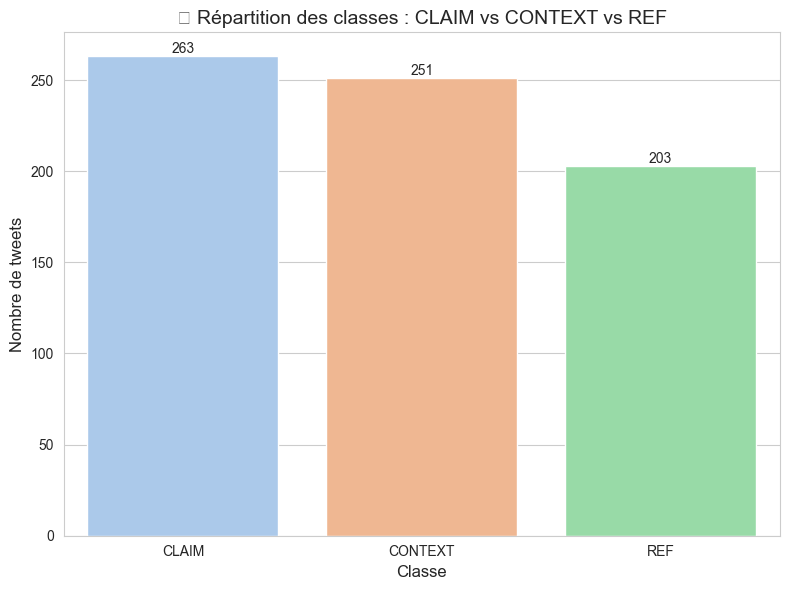

In [82]:

import matplotlib.pyplot as plt
import seaborn as sns

# Comptage des classes
counts = df_multi["label_text"].value_counts().reset_index()
counts.columns = ["Classe", "Nombre"]

# Barplot avec seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
bar = sns.barplot(data=counts, x="Classe", y="Nombre", palette="pastel")

# Titre et axes
plt.title("📊 Répartition des classes : CLAIM vs CONTEXT vs REF", fontsize=14)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre de tweets", fontsize=12)

# Affichage des valeurs sur les barres
for p in bar.patches:
    bar.annotate(format(p.get_height(), '.0f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [83]:
#-------------------------------
#----Nettoyage + normalisation du texte--------
#------------------------------

In [84]:
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convertir les emojis en texte (tweet_text)
def convert_emojis(text):
    return emoji.demojize(str(text))

df_multi['tweet_text'] = df_multi['text'].apply(convert_emojis)

# 2. Détection des éléments textuels
df_multi['has_url'] = df_multi['text'].str.contains(r'http[s]?://', regex=True)
df_multi['has_mention'] = df_multi['text'].str.contains(r'@\w+', regex=True)
df_multi['has_hashtag'] = df_multi['text'].str.contains(r'#\w+', regex=True)
df_multi['has_emoji'] = df_multi['tweet_text'].str.contains(r':[^:\s]+:', regex=True)

# 3. Fonction pour compter par classe (label_text)
def count_by_category(col):
    return df_multi.groupby('label_text')[col].sum()

# 4. Affichage des statistiques
print("- Tweets avec URL :")
display(count_by_category('has_url'))

print("- Tweets avec Mention :")
display(count_by_category('has_mention'))

print("- Tweets avec Hashtag :")
display(count_by_category('has_hashtag'))

print("- Tweets avec Emoji :")
display(count_by_category('has_emoji'))


- Tweets avec URL :


label_text
CLAIM      197
CONTEXT    236
REF        199
Name: has_url, dtype: int64

- Tweets avec Mention :


label_text
CLAIM      57
CONTEXT    73
REF        50
Name: has_mention, dtype: int64

- Tweets avec Hashtag :


label_text
CLAIM      76
CONTEXT    84
REF        65
Name: has_hashtag, dtype: int64

- Tweets avec Emoji :


label_text
CLAIM      5
CONTEXT    2
REF        2
Name: has_emoji, dtype: int64

In [ ]:
#------------------------------------------------------------
#--------matrice tf-idf avce les données brut---------------
#-------------------------------------------------------------

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# Étape 1 : Supprimer les lignes sans texte
df_multi.dropna(subset=['tweet_text'], inplace=True)

# Étape 2 : Sélection du texte brut et du label multiclasses
X_text = df_multi['tweet_text']
y = df_multi['label']  # 0 = CLAIM, 1 = CONTEXT, 2 = REF

# Étape 3 : Création de la matrice TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# Étape 4 : Création de la matrice des features binaires supplémentaires
extra_features = df_multi[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
X_extra = scipy.sparse.csr_matrix(extra_features.values)

# Étape 5 : Concaténation TF-IDF + features supplémentaires
X_final = scipy.sparse.hstack([X_tfidf, X_extra])

# Étape 6 : Affichage des dimensions
print("Taille de la matrice TF-IDF :", X_tfidf.shape)
print("Taille des features supplémentaires :", X_extra.shape)
print("Taille finale (TF-IDF + features) :", X_final.shape)


Taille de la matrice TF-IDF : (717, 3372)
Taille des features supplémentaires : (717, 4)
Taille finale (TF-IDF + features) : (717, 3376)


In [86]:
import re
import pandas as pd

# Convertir la matrice TF-IDF en DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Fonction de catégorisation des tokens
def get_token_category(token):
    if token.isdigit():
        return 'numeric'
    if re.match(r'^\d+(am|pm|s|h|min|sec|hour|years)?$', token.lower()):
        return 'timestamp'
    if re.match(r'^[a-zA-Z]+$', token):
        return 'valid'
    return 'other'

# Classer chaque token selon son type
token_categories = {token: get_token_category(token) for token in tfidf_df.columns}

# Séparer les colonnes par catégorie
valid_tokens = [token for token, cat in token_categories.items() if cat == 'valid']
numeric_tokens = [token for token, cat in token_categories.items() if cat == 'numeric']
timestamp_tokens = [token for token, cat in token_categories.items() if cat == 'timestamp']

# Colonnes synthétiques : total de valeurs numériques et timestamps par ligne
tfidf_df['numeric'] = tfidf_df[numeric_tokens].sum(axis=1) if numeric_tokens else 0
tfidf_df['timestamp'] = tfidf_df[timestamp_tokens].sum(axis=1) if timestamp_tokens else 0

# Conserver uniquement les tokens valides et les colonnes synthétiques
tfidf_cleaned = tfidf_df[valid_tokens + ['numeric', 'timestamp']]

# Aperçu
print("Aperçu de la matrice TF-IDF nettoyée :")
display(tfidf_cleaned.head())
print("Taille finale :", tfidf_cleaned.shape)


Aperçu de la matrice TF-IDF nettoyée :


,ability,able,abnormal,abortion,abortions,about,absolute,abstract,abuse,abuser,...,yrs,yvandutil,zachary,zheng,zhengli,zhu,zika,zjghyzrngd,numeric,timestamp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Taille finale : (717, 2905)


In [87]:
#------------------------------------------------------------
#--------train et evaluation---------------
#-------------------------------------------------------------

,Accuracy,Precision,Recall,F1 Score
Naïve Bayes,0.223 ± 0.035,0.202,0.223,0.207
Logistic Regression,0.226 ± 0.026,0.208,0.226,0.215
Multinomial NB,0.223 ± 0.035,0.202,0.223,0.207
Random Forest,0.211 ± 0.022,0.215,0.211,0.211
SVM,0.229 ± 0.028,0.211,0.229,0.218
KNN,0.307 ± 0.020,0.261,0.307,0.272
AdaBoost,0.437 ± 0.008,0.408,0.437,0.370
Gradient Boosting,0.205 ± 0.027,0.243,0.205,0.217
XGBoost,0.211 ± 0.026,0.215,0.211,0.211
Neural Network (MLP),0.223 ± 0.026,0.216,0.223,0.218


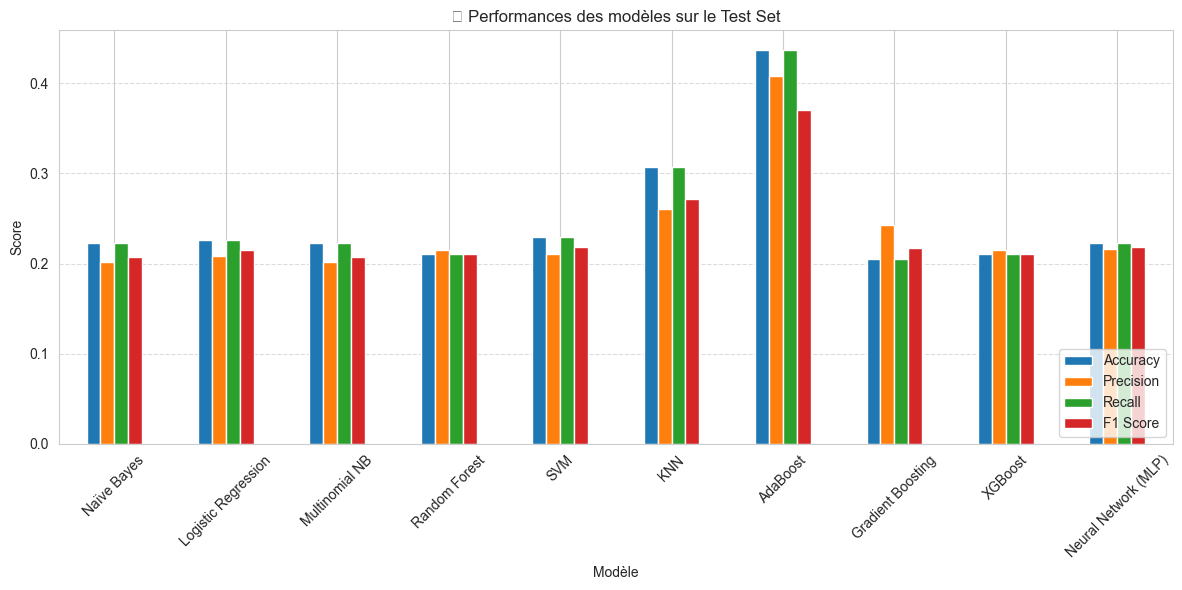

In [90]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# ✅ Dictionnaire des modèles
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Multinomial NB": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "SVM": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Neural Network (MLP)": MLPClassifier(max_iter=300)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = {}

X = X_final

# Boucle sur chaque modèle
for model_name, model in models.items():
    acc_list, prec_list, rec_list, f1_list = [], [], [], []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            acc_list.append(accuracy_score(y_test, y_pred))
            prec_list.append(precision_score(y_test, y_pred, average='weighted'))
            rec_list.append(recall_score(y_test, y_pred, average='weighted'))
            f1_list.append(f1_score(y_test, y_pred, average='weighted'))
        
        except Exception as e:
            print(f"❌ Erreur pour {model_name} : {e}")
            acc_list.append(np.nan)
            prec_list.append(np.nan)
            rec_list.append(np.nan)
            f1_list.append(np.nan)
    
    # Résumé des scores pour le modèle courant
    scores[model_name] = {
        "Accuracy": f"{np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}",
        "Precision": f"{np.mean(prec_list):.3f}",
        "Recall": f"{np.mean(rec_list):.3f}",
        "F1 Score": f"{np.mean(f1_list):.3f}",
    }

df_scores = pd.DataFrame(scores).T

display(df_scores)

# On extrait uniquement les moyennes numériques (pas l'écart-type)
plot_df = df_scores[["Accuracy", "Precision", "Recall", "F1 Score"]].copy()
plot_df["Accuracy"] = plot_df["Accuracy"].str.extract(r"([\d\.]+)").astype(float)
plot_df[["Precision", "Recall", "F1 Score"]] = plot_df[["Precision", "Recall", "F1 Score"]].astype(float)

plot_df.plot(kind='bar', figsize=(12, 6))
plt.title("📊 Performances des modèles sur le Test Set")
plt.xlabel("Modèle")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()